In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch

# Plotting
import plotly.figure_factory as ff
import plotly.graph_objects as go

torch.set_printoptions(sci_mode = False)
np.set_printoptions(suppress = True)

# Ice flux from Bedmachine data

- random example see below
- all data are 2D arrays

In [24]:
# x and y both shape (20, 20)
x, y = np.meshgrid(
    np.arange(-2, 2, 0.2),
    np.arange(-2, 2, 0.2))

# z is a function of x and y
z = x * np.exp(-x**2 - y**2)
# v and u show the gradients of z
v, u = np.gradient(z, 0.2, 0.2)

# Create quiver figure
fig = ff.create_quiver(x, y, u, v,
                       scale = 0.25, # scaler on the arrow
                       arrow_scale = 0.4, #increases size of the pointy part of the arrow
                       name = 'quiver',
                       line_width = 1)

fig.update_layout(width = 800, height = 800)
fig.update_layout(template = "plotly_white")

fig.update_layout(title = 'Example Quiver Plot (diverging)')

fig.show()

# Load 2D tensor of ice velocity

This was already interpolated.
Has some zeros.

In [25]:
ice_vel_byrd_tensor = torch.load("/home/kim/ice_thickness/data/ice_vel_myr_VX_VY_x_y.pt")
ice_vel_byrd_tensor.shape

torch.Size([4, 400, 400])

# Load 2D tensor of ice thickness

In [26]:
ice_thickness_byrd_tensor = torch.load("/home/kim/ice_thickness/data/icethickness_bedmachine_m_h_x_y.pt")
ice_thickness_byrd_tensor[0, :, :]

tensor([[ 279.3724,  289.7424,  300.0978,  ..., 2704.9246, 2706.1292,
         2701.9038],
        [ 272.7039,  282.8789,  293.0232,  ..., 2697.3867, 2697.6777,
         2691.2205],
        [ 266.0718,  276.0520,  285.9866,  ..., 2687.3899, 2689.9590,
         2681.2871],
        ...,
        [ 681.7672,  728.0835,  665.7770,  ..., 1410.2407, 1383.3877,
         1365.6091],
        [ 723.1245,  683.6618,  641.9525,  ..., 1439.5344, 1412.0428,
         1395.3517],
        [ 654.3364,  648.4701,  638.5720,  ..., 1475.3903, 1447.6348,
         1433.3270]], dtype=torch.float64)

## Assert that we are using the same grids

In [27]:
print((ice_thickness_byrd_tensor[1, :, :] == ice_vel_byrd_tensor[2]).all())
print((ice_thickness_byrd_tensor[2, :, :] == ice_vel_byrd_tensor[3]).all())

tensor(True)
tensor(True)


## Avoid missing values

In [28]:
ice_vel_byrd_tensor[0] = torch.nan_to_num(ice_vel_byrd_tensor[0], nan = 0.0)
ice_vel_byrd_tensor[1] = torch.nan_to_num(ice_vel_byrd_tensor[1], nan = 0.0)

## Combine flux data

In [29]:
flux_tensor = torch.concat([
             torch.mul(ice_thickness_byrd_tensor[0], ice_vel_byrd_tensor[0]).unsqueeze(0), # ice flux x
             torch.mul(ice_thickness_byrd_tensor[0], ice_vel_byrd_tensor[1]).unsqueeze(0), # ice flux y
             ice_vel_byrd_tensor[0].unsqueeze(0), # vx
             ice_vel_byrd_tensor[1].unsqueeze(0), # vy
             ice_thickness_byrd_tensor[0].unsqueeze(0), # ice thickness h
             ice_thickness_byrd_tensor[1].unsqueeze(0), # x
             ice_thickness_byrd_tensor[2].unsqueeze(0)], # y
             dim = 0)

In [30]:
torch.save(flux_tensor, "data/flux_byrd_fluxx_fluxy_vx_vy_h_x_y.pt")

In [31]:
np.gradient(flux_tensor[0, :, :], 500, axis = 1) == np.gradient(flux_tensor[0, :, :], 1, axis = 1)/500

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [32]:
print(np.gradient(flux_tensor[0, :, :], 500, axis = 1).max())
print(np.gradient(flux_tensor[0, :, :], 500, axis = 1).min())

460.51447701836
-296.5518583531445


In [33]:
print(np.gradient(flux_tensor[1, :, :], 500, axis = 0).max())
print(np.gradient(flux_tensor[1, :, :], 500, axis = 0).min())

477.49594176050647
-238.67003228648753


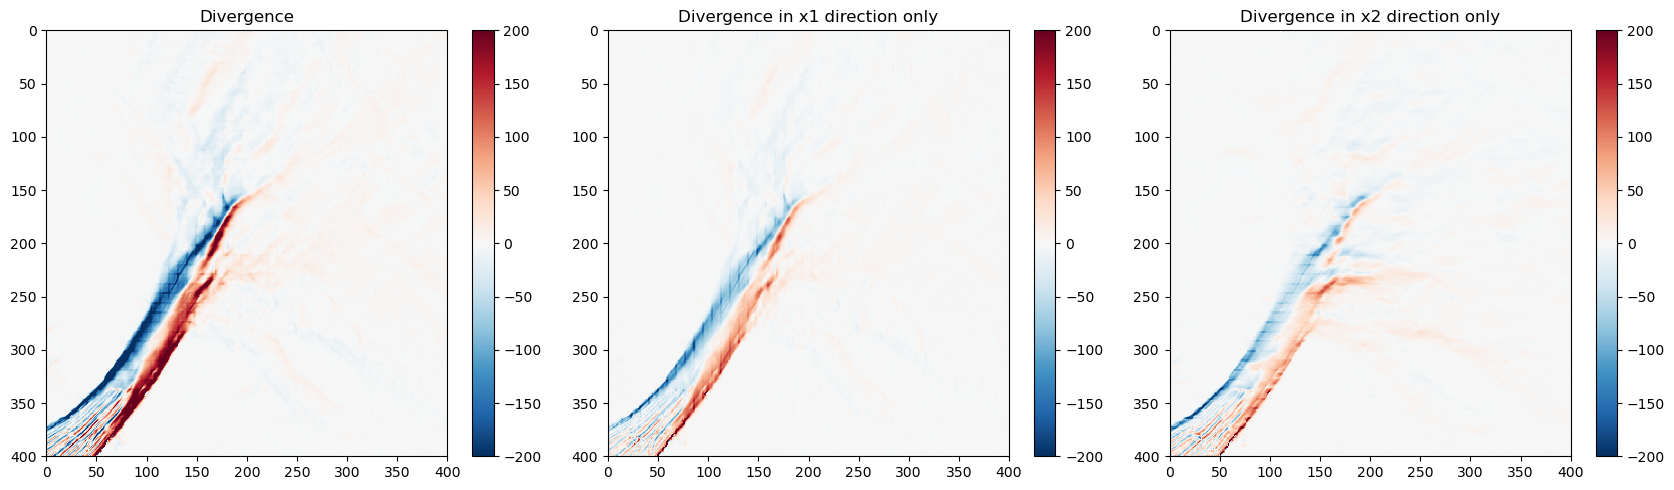

In [34]:
flux_tensor
# 0.5 km dx
dxy = 500 
# this is essentially just scaling: default is 1, so diving by 500 to get divergence per meter
np.gradient(flux_tensor[0, :, :], dxy, axis = 1)

# Compute gradients (finite differences)
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize = (17, 5))

combined_color_max = 200
color_max = 200

# First subplot: Divergence
c1 = axs[0].pcolormesh((np.gradient(flux_tensor[0, :, :], dxy, axis = 1) + np.gradient(flux_tensor[1, :, :], dxy, axis = 0)), cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
# Invert y-axis to match tensor indexing
axs[0].invert_yaxis()
axs[0].set_title('Divergence')
fig.colorbar(c1, ax = axs[0])

# First subplot: Divergence in x1 direction
c2 = axs[1].pcolormesh(np.gradient(flux_tensor[0, :, :], dxy, axis = 1), cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
axs[1].invert_yaxis()
axs[1].set_title('Divergence in x1 direction only')
fig.colorbar(c2, ax = axs[1])

# Second subplot: Divergence in x2 direction
c3 = axs[2].pcolormesh(np.gradient(flux_tensor[0, :, :], dxy, axis = 0), cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
axs[2].invert_yaxis()
axs[2].set_title('Divergence in x2 direction only')
fig.colorbar(c3, ax = axs[2])

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
flux_tensor[1, :, :].mean()

tensor(-73283.3049, dtype=torch.float64)

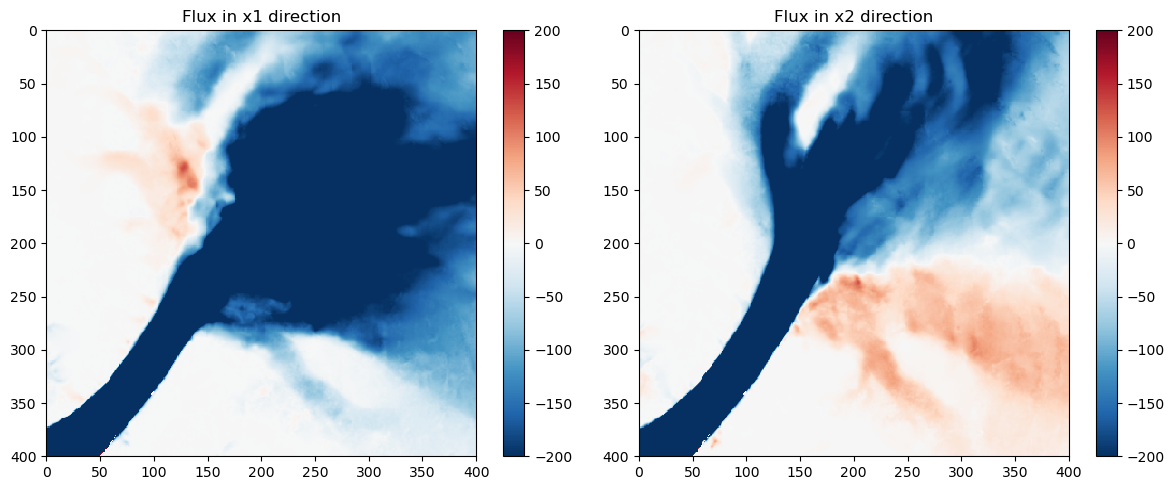

In [36]:
flux_tensor
# 0.5 km dx
dxy = 500
np.gradient(flux_tensor[0, :, :], dxy, axis = 1)

# Compute gradients (finite differences)
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

combined_color_max = 200
color_max = 200

# First subplot: Divergence
c1 = axs[0].pcolormesh(flux_tensor[0, :, :]/dxy, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
# Invert y-axis to match tensor indexing
axs[0].invert_yaxis()
axs[0].set_title('Flux in x1 direction')
fig.colorbar(c1, ax = axs[0])

# First subplot: Divergence in x1 direction
c1 = axs[1].pcolormesh(flux_tensor[1, :, :]/dxy, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
axs[1].invert_yaxis()
axs[1].set_title('Flux in x2 direction')
fig.colorbar(c2, ax = axs[1])

# Show the plot
plt.tight_layout()
plt.show()

# Plot quiverplot with Plotly

- 400 x 400 is too big. Takes too long
- color of quiver

In [37]:
# unsqueeze for minibatch format
factor = 10
flux_tensor_lowres = torch.nn.functional.avg_pool2d(flux_tensor.unsqueeze(0), kernel_size = factor, stride = factor, padding = 0)[0]

print(flux_tensor_lowres.shape)

torch.Size([7, 40, 40])


In [38]:
print(flux_tensor_lowres[1].min())
print(flux_tensor_lowres[1].max())

tensor(-1366204.2243, dtype=torch.float64)
tensor(44086.6549, dtype=torch.float64)


In [39]:
print(flux_tensor_lowres[0].min())
print(flux_tensor_lowres[0].max())

tensor(-869662.4164, dtype=torch.float64)
tensor(46002.4615, dtype=torch.float64)


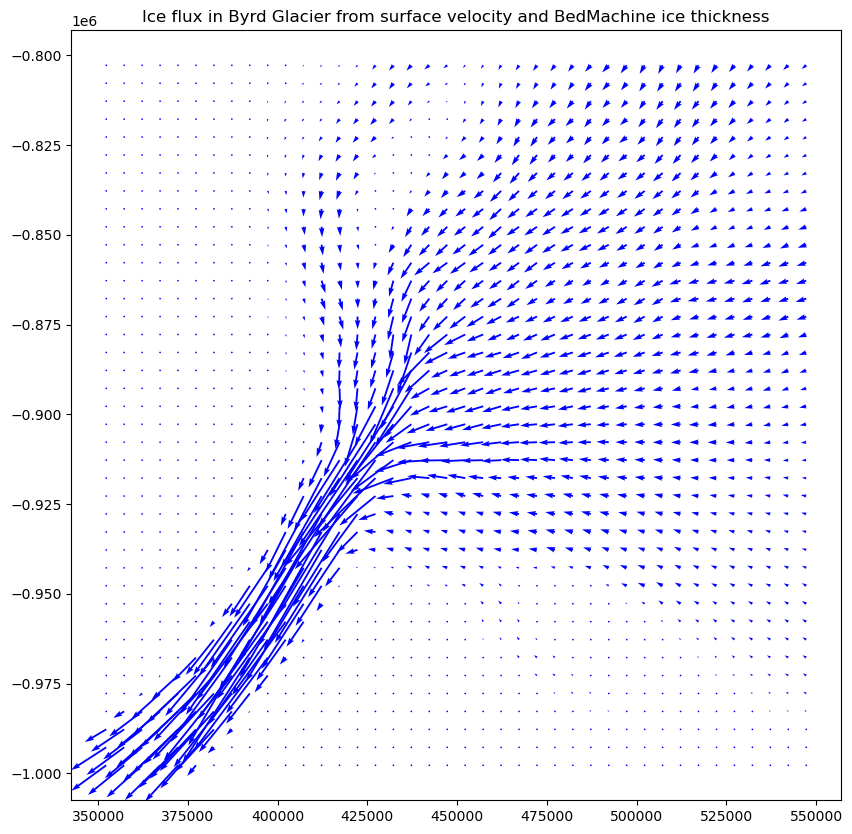

In [40]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.quiver(flux_tensor_lowres[5], # x meshgrid
          flux_tensor_lowres[6], # y meshgrid
          flux_tensor_lowres[0], # flux in x direction
          flux_tensor_lowres[1], # flux in y direction
          color = 'blue')

ax.set_aspect('equal')

plt.title('Ice flux in Byrd Glacier from surface velocity and BedMachine ice thickness')
plt.show()

# Add magnitude

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html

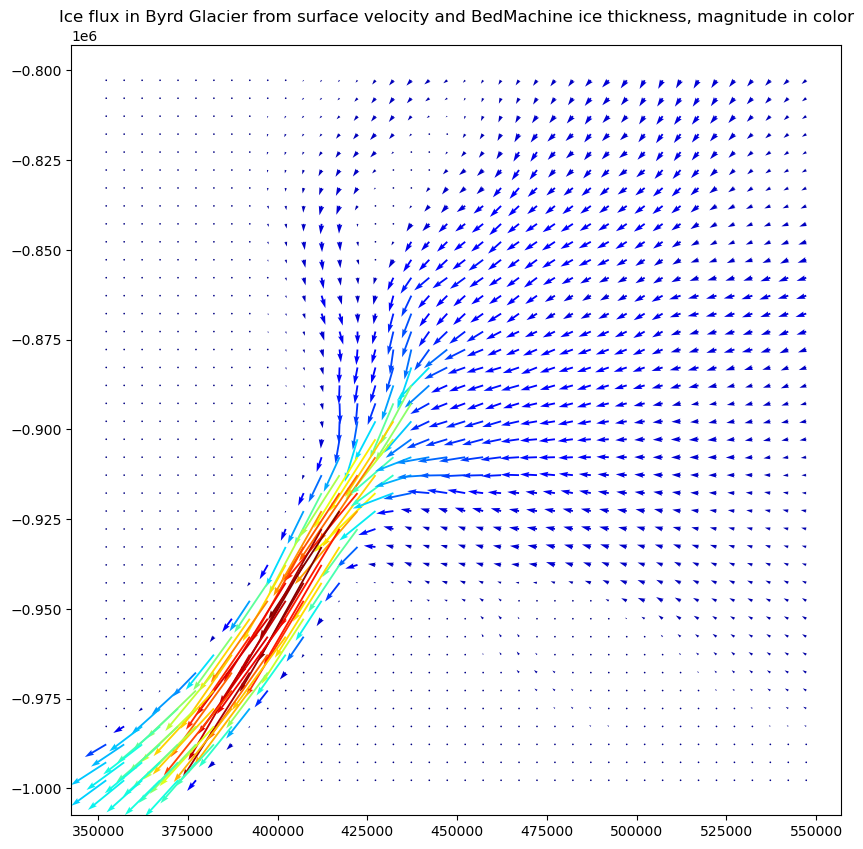

In [41]:
fig, ax = plt.subplots(figsize = (10, 10))

quiver = plt.quiver(flux_tensor_lowres[5], # x meshgrid
          flux_tensor_lowres[6], # y meshgrid
          flux_tensor_lowres[0], # flux in x direction
          flux_tensor_lowres[1], # flux in y direction
          torch.sqrt(torch.square(flux_tensor_lowres[0]) + torch.square(flux_tensor_lowres[1])), # magnitude of flux
          cmap = plt.cm.jet)

# plt.colorbar(quiver, cmap = plt.cm.jet)

ax.set_aspect('equal')
plt.title('Ice flux in Byrd Glacier from surface velocity and BedMachine ice thickness, magnitude in color')
plt.show()

# Extract automatic quiver params

In [76]:
print(quiver.scale)
print(quiver.width)

9240970.30047411
0.0024


In [49]:
fig = ff.create_quiver(flux_tensor_lowres[5], # x meshgrid
                       flux_tensor_lowres[6], # y meshgrid
                       flux_tensor_lowres[0], # flux x
                       flux_tensor_lowres[1], # flux y
                       # scale = 0.25, # scaler on the arrow
                       # arrow_scale = 0.4, #increases size of the pointy part of the arrow
                       name = 'quiver',
                       line_width = 1)

fig.update_layout(width = 800, height = 800)
fig.update_layout(template = "plotly_white")

fig.update_layout(title = "Ice flux")

fig.show()

In [46]:
# sign preserving log transformation

tensor([[ -5.1884,  -5.0774,   6.4233,  ..., -11.0450, -11.0341, -10.9272],
        [  6.4013,   6.7464,   6.9890,  ..., -11.0484, -10.9503, -10.8466],
        [  6.5650,   7.1310,   7.1131,  ..., -10.9759, -10.8975, -10.8507],
        ...,
        [-12.4548, -12.8940, -13.0544,  ...,  -9.5476,  -9.5735,  -9.6271],
        [-12.9522, -13.0208, -13.0134,  ...,  -9.3336,  -9.3220,  -9.4006],
        [-12.9425, -12.9824, -12.9648,  ...,  -9.1981,  -9.1241,  -9.3381]],
       dtype=torch.float64)

In [47]:
# Create quiver figure
# Is it per meter?!
fig = ff.create_quiver(flux_tensor_lowres[5], # x meshgrid
                       flux_tensor_lowres[6], # y meshgrid
                       torch.sign(flux_tensor_lowres[0]) * torch.log(1 + torch.abs(flux_tensor_lowres[0])), # flux x
                       torch.sign(flux_tensor_lowres[1]) * torch.log(1 + torch.abs(flux_tensor_lowres[1])),
                       # scale = 0.25, # scaler on the arrow
                       # arrow_scale = 0.4, #increases size of the pointy part of the arrow
                       name = 'quiver',
                       line_width = 1)

fig.update_layout(width = 800, height = 800)
fig.update_layout(template = "plotly_white")

fig.update_layout(title = "Ice flux (sign-preserving log scale)")

fig.show()